# Dev.Eats Notebook

This notebook serves as the initial experimentation and inference script for the `Dev.Eats` application. Please connect to a GPU runtime before initializing the codebase.

## Install Necessary Packages

This section installs the necessary libraries/packages for image analysis. I have decided to use Open AI's CLIP (Contrastive Language-Image Pre-training) library to assist with this task. The commands install the following packages:

- `!pip install -q git+https://github.com/openai/CLIP.git`, Installs the Open AI CLIP package, providing tools for working with images and text.
- `!pip install -q scikit-learn matplotlib seaborn`: Packages for model inference and data visualization.
- `!pip install -q tqdm`: Progress bar library to visualize notebook state.

In [1]:
!pip install -q git+https://github.com/openai/CLIP.git
!pip install -q scikit-learn matplotlib seaborn
!pip install -q tqdm

print("✅ Libraries installed.")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.9 MB/s eta 0:00:00
✅ Libraries installed.


## Load CLIP Model & Food Dataset

For the remainder of this notebook, a GPU is required for faster computation. To remove this requirement, please comment out the `torch.cuda.is_available()` line and replace the `device = "cuda"` with `device = "cpu"`.

After analyzing the available CLIP models, I have selected `ViT-B/32`, which is a medium-sized (`B`) vision transformer (`ViT`) with a 32-pixel image patch size for processing (`32`). This model/preprocessor combination will allow us to process images and text simultaneously, which will help us narrow the scope of image identification.

For this project, I have selected the Food-101 dataset, using the `test` set to experiment with the CLIP model. After downloading this dataset, it is loaded into a `DataLoader` and processed using the indicated `ViT-B/32` preprocessor.

In [2]:
import torch
import clip
from torchvision.datasets import Food101
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
import random

# Check for GPU
if not torch.cuda.is_available():
   raise OSError("Running on CPU. Please update your runtime!")
device = "cuda"

# Load the CLIP model and the image preprocessor
model, preprocess = clip.load("ViT-B/32", device=device)
print("\n✅ CLIP Model ViT-B/32 loaded.")

# Load the Food-101 TEST dataset
# The preprocessor from CLIP will be used to transform the images
dataset = Food101(root=".", split="test", download=True, transform=preprocess)

# Create a DataLoader for efficient processing
dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

print(f"\n✅ Food-101 test dataset loaded.")
print(f"   - Number of images: {len(dataset)}")
print(f"   - Number of classes: {len(dataset.classes)}")
print(f"   - Example class: '{random.choice(dataset.classes)}'")

100%|███████████████████████████████████████| 338M/338M [00:24<00:00, 14.6MiB/s]



✅ CLIP Model ViT-B/32 loaded.


100%|██████████| 5.00G/5.00G [03:44<00:00, 22.2MB/s]



✅ Food-101 test dataset loaded.
   - Number of images: 25250
   - Number of classes: 101
   - Example class: 'strawberry_shortcake'


## Define and Tokenize Text Prompts

Here, we generate a set of textual descriptions for various food classes from the Food-101 dataset. These descriptions are designed to be used as prompts for the CLIP model, allowing it to learn and generate meaningful features associated with each food item.

After examining current research on prompting techniques for text-images models, I decided to construct a list of template phrases that provide more contextual to the model. Each food-class name will be formatted into each of these templates, creating a collection of descriptive food-texts.

Utilizing the CLIP model, each text prompt is tokenized and encoded into normalized feature vectors. Lastly, the mean feature vector is computed to obtain a consolidated representation for each food class.

In [3]:
templates = [
    'a photo of {}, a type of food.',
    'a photo of freshly made {}.',
    'food photography of {}.',
    'a photo of {}, a popular dish.',
    'a close-up photo of {} on a plate.',
    'an appetizing image of {}.',
    'an Instagram-style photo of {} with natural lighting',
    'a macro photo of {}.',
    'a mouth-watering shot of {}.',
    'a detailed close-up of {}, gourmet presentation.',
    'a top-down food photo of {}.',
    'a good photo of {}.',
    'a photo of my {}.',
    'a close-up photo of {}.',
    'a photo of the {}.',
    'a beautifully plated {} ready to be served.',
    'a lifestyle shot of someone about to eat {}.',
    '{} photographed with a shallow depth of field.',
    'a candid photo of {}, ready to be eaten.'
]

all_features = []

with torch.no_grad():
    for class_name in tqdm(dataset.classes, desc="Encoding prompts"):
        texts = [ template.format(class_name) for template in templates ]
        tokens = clip.tokenize(texts).to(device)

        class_features = model.encode_text(tokens)
        class_features /= class_features.norm(dim=-1, keepdim=True)

        mean_features = class_features.mean(dim=0)
        mean_features /= mean_features.norm()

        all_features.append(mean_features)

features = torch.stack(all_features, dim=0)

print("\n✅ All text prompts tokenized and encoded.")

Encoding prompts: 100%|██████████| 101/101 [00:02<00:00, 37.13it/s]


✅ All text prompts tokenized and encoded.


## Inference/Predictions

This cell iterates through the preloaded Food101 test dataset and predicts the food classes for all images. The goal is to evaluate how well the CLIP model, combined with tokenized, descriptive text prompts, can classify the images.

To compute the predicitons, we start by loading a batch of images and labels and encode them to obtain a set of feature vectors. We then compute the similarity between the image features and the precomputed text features for each class. Using this similarity score, we extract the top predicted classes.

In [6]:
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in tqdm(dataloader, desc="Running Inference"):
        images = images.to(device)
        labels = labels.to(device)

        # Encode images
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # Calculate similarity
        similarity = (100.0 * image_features @ features.T).softmax(dim=-1)

        # Get predictions
        _, preds = torch.topk(similarity, k=1, dim=-1)

        all_preds.append(preds.squeeze(1).cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

print("\n✅ Inference complete.")

Running Inference: 100%|██████████| 198/198 [03:30<00:00,  1.07s/it]


✅ Inference complete.


## Quantitative Analysis (Calculate Metrics and Generate Figures)

We can now evaluate the performance of the CLIP model on the Food101 test dataset by calculating accuracy and generating a confusion matrix.

To start, this section compares the predicted labels with the true labels to compute an accuracy score. We then use the `sklearn` `confusion_matrix` method to visualize the model's classification results. The confusion matrix illustrates the counts of true positive, false positive, false negative, and true negative predictions for each class.

For confusion_matrix visualization for this many classes, I decided to render the results in a heatmap.

Accuracy Results: 0.8462

Generating confusion matrix for model...


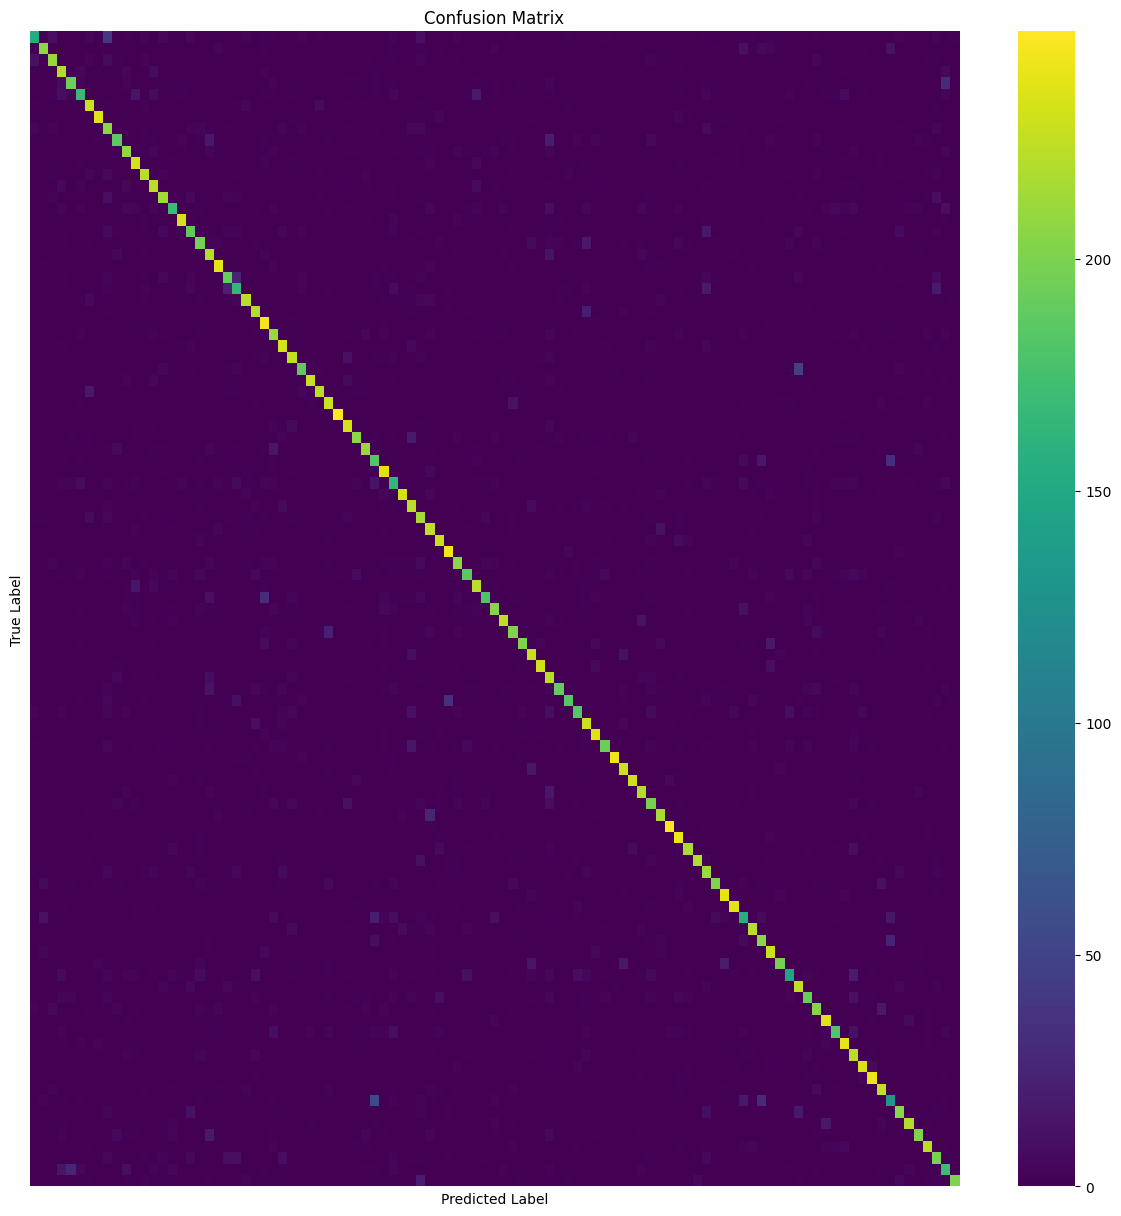

✅ Confusion matrix saved as 'confusion_matrix.png'


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Calculate accuracies
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy Results: {accuracy:.4f}")

# Generate Confusion Matrix
print("\nGenerating confusion matrix for model...")
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=False, xticklabels=False, yticklabels=False, cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')
plt.show()

print("✅ Confusion matrix saved as 'confusion_matrix.png'")

## Qualitative Analysis (Example)

Now that we have determined the model's overall performance, we can view specific examples to get a better understanding of what the model is "seeing". These specific examples can help provide direction for future areas of improvement.

We start by separating the `correct` and `incorrect` indices, and define a function for highlighting the image with the true and prediction labels.

We can then visualize a few examples of correct and incorrect examples. From this we can see that the model does a good job of classifying food, especially given that no additional training occurred.

Found 21367 correct predictions.
Found 3883 incorrect predictions.

--- Correct Prediction Examples ---


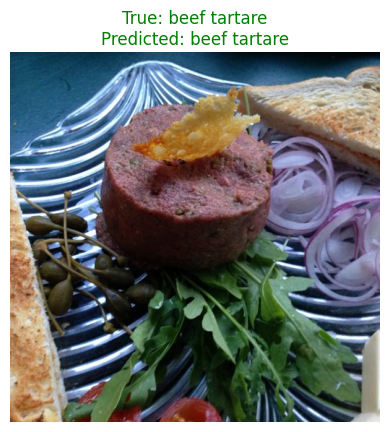

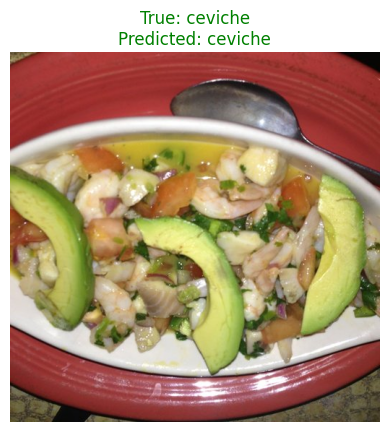

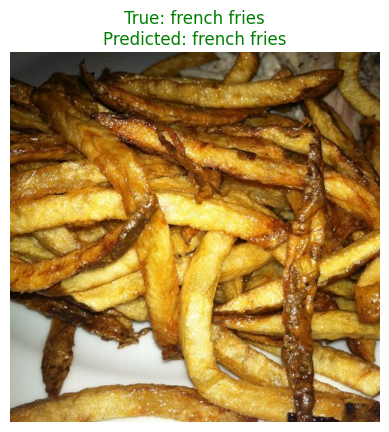


--- Incorrect Prediction Examples ---


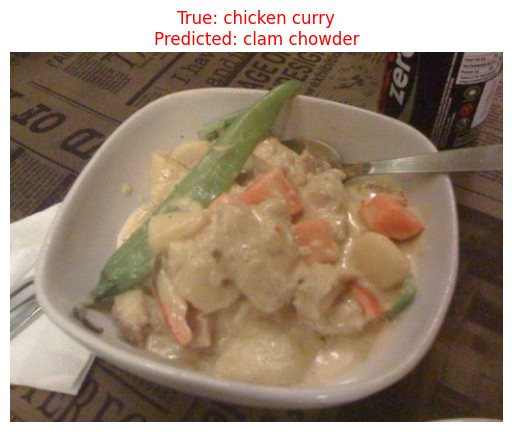

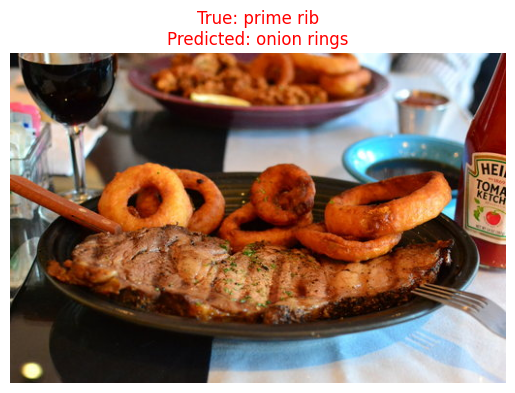

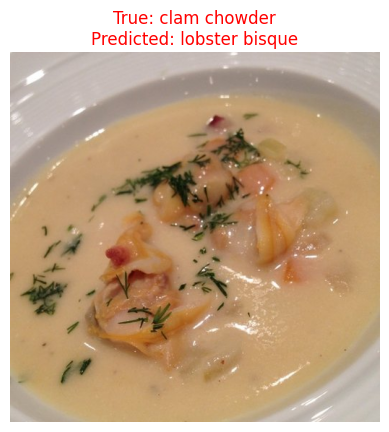

In [10]:
# Find indices of correct and incorrect predictions
correct = [i for i, (p, t) in enumerate(zip(all_preds, all_labels)) if p == t]
incorrect = [i for i, (p, t) in enumerate(zip(all_preds, all_labels)) if p != t]

print(f"Found {len(correct)} correct predictions.")
print(f"Found {len(incorrect)} incorrect predictions.")

def display_example(index, is_correct=True):
    # Extract original image and label
    image, label = Food101(root=".", split="test")[index]
    pred = all_preds[index].item()

    plt.imshow(image)
    label_str = dataset.classes[label]
    pred_str = dataset.classes[pred]

    title_color = 'green' if is_correct else 'red'
    plt.title(f"True: {label_str}\nPredicted: {pred_str}", color=title_color)
    plt.axis('off')
    plt.show()

N_EXAMPLES = 3

print("Correct Examples")
for _ in range(N_EXAMPLES):
    display_example(random.choice(correct), is_correct=True)

print("\nIncorrect Examples")
for _ in range(N_EXAMPLES):
    display_example(random.choice(incorrect), is_correct=False)